# Synthetic Dataset 2a: Friedman Function w/o Linear Terms

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [2]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/')
import tools_general as tg
import tools_pytorch as tp
import lockout       as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockout' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/lockout.py'>

## Generate and save data

In [3]:
# Generate 'train, valid, & test datasets
torch.manual_seed(42)
samples = 1000
n_features = 200
generate_flag = True
pi = torch.Tensor([np.pi])

xtrain = torch.rand(samples,n_features)
ytrain = torch.zeros(samples)
ytrain[:] = 10.0*torch.sin(pi*xtrain[:,0]*xtrain[:,1]) + 20.0*(xtrain[:,2] - 0.5)**2

xvalid = torch.rand(samples,n_features)
yvalid = torch.zeros(samples)
yvalid[:] = 10.0*torch.sin(pi*xvalid[:,0]*xvalid[:,1]) + 20.0*(xvalid[:,2] - 0.5)**2

xtest = torch.rand(samples,n_features)
ytest = torch.zeros(samples)
ytest[:] = 10.0*torch.sin(pi*xtest[:,0]*xtest[:,1]) + 20.0*(xtest[:,2] - 0.5)**2

y_std = ytrain.std()
print("MEAN of 'ytrain' before adding noise =", ytrain.mean().item())
print("STD of 'ytrain' before adding noise =", y_std.item())

y_std = 0.5*y_std
y_mean = 0.0
print("\nGaussian noise added to 'ytrain with:")
print("- mean =", y_mean)
print("- std =", y_std.item())

ynoise1 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
ytrain[:] += ynoise1[:,0]
# ynoise2 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
# yvalid[:] += ynoise2[:,0]

MEAN of 'ytrain' before adding noise = 7.238823413848877
STD of 'ytrain' before adding noise = 3.652416706085205

Gaussian noise added to 'ytrain with:
- mean = 0.0
- std = 1.8262083530426025


In [4]:
# Convert to Pandas DataFrames
cols_X = [str(i) for i in range(1, n_features+1)]
df_xtrain = pd.DataFrame(xtrain.numpy(), columns=cols_X)
df_xvalid = pd.DataFrame(xvalid.numpy(), columns=cols_X)
df_xtest  = pd.DataFrame(xtest.numpy(), columns=cols_X)
cols_X = df_xtrain.columns.tolist()

cols_Y = ['target']
df_ytrain = pd.DataFrame(ytrain.numpy(), columns=cols_Y)
df_yvalid = pd.DataFrame(yvalid.numpy(), columns=cols_Y)
df_ytest = pd.DataFrame(ytest.numpy(), columns=cols_Y)

In [6]:
# Save data set
tg.save_data(df_xtrain, df_xtrain, df_xvalid, df_xtest, 
             df_ytrain, df_ytrain, df_yvalid, df_ytest, 'dataset_a/')
tg.save_list(cols_X, 'dataset_a/X.columns')
tg.save_list(cols_Y, 'dataset_a/Y.columns')

# 
print("- xtrain size: {}".format(df_xtrain.shape))
print("- xvalid size: {}".format(df_xvalid.shape))
print("- xtest size: {}".format(df_xtest.shape))

- xtrain size: (1000, 200)
- xvalid size: (1000, 200)
- xtest size: (1000, 200)


## Load Data

In [5]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [6]:
# Read data
_, x_train, x_valid, x_test, _, y_train, y_valid, y_test = tp.load_data_reg('dataset_a/')
cols_X = tg.read_list('dataset_a/X.columns')
cols_Y = tg.read_list('dataset_a/Y.columns')

In [9]:
# Normalize data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tp.normalize_xy(x_train, x_valid, x_test, 
                                                               y_train, y_valid, y_test)

In [10]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [19]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [3]:
# NN architecture with its corresponding forward method
class MyNetRes(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNetRes, self).__init__()
        
        self.nodes_out = layer_sizes[-1]
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(features, layer_sizes[0], bias=True)
        self.fc2 = nn.Linear(layer_sizes[0]-layer_sizes[-1], layer_sizes[1], bias=True)

# .Forward function
    def forward(self, x):
        x = self.fc1(x)
        x1 = x[:,-self.nodes_out:]
        x2 = x[:,:-self.nodes_out]
        x2 = self.relu(x2)
        x2 = self.fc2(x2)
        x = x1 + x2
        return x

## Lasso

In [87]:
# Grid search space
grid_alpha = np.geomspace(1e-4, 1.0, num=500)
data_lasso = pd.DataFrame(columns = ['iteration', 'alpha', 'sparcity', 
                                     'valid_loss', 'train_loss', 'test_loss',
                                     'valid_accu', 'train_accu', 'test_accu'])

params = {'max_iter': 100000,
          'random_state': 42,
          'warm_start': True}

In [88]:
# Perform grid search
t0_list = []
iterator = tqdm.notebook.tqdm(range(1, len(grid_alpha) + 1), desc='alpha-grid loop')
for n in iterator:
    irow = n-1
    dict_tmp = {'iteration': n, 'alpha': grid_alpha[irow]}
    params['alpha'] = grid_alpha[irow]
    log_reg = Lasso(**params).fit(xtrain.numpy(), ytrain.numpy().ravel())
    
    ypred = log_reg.predict(xtrain.numpy())
    mse = mean_squared_error(ytrain.numpy(), ypred, squared=True)
    r2  = r2_score(ytrain.numpy(), ypred)
    dict_tmp.update({'train_loss': mse, 'train_accu': r2})
    
    ypred = log_reg.predict(xvalid.numpy())
    mse = mean_squared_error(yvalid.numpy(), ypred, squared=True)
    r2  = r2_score(yvalid.numpy(), ypred)
    dict_tmp.update({'valid_loss': mse, 'valid_accu': r2})
    
    ypred = log_reg.predict(xtest.numpy())
    mse = mean_squared_error(ytest.numpy(), ypred, squared=True)
    r2  = r2_score(ytest.numpy(), ypred)
    dict_tmp.update({'test_loss': mse, 'test_accu': r2})
    
    ctmp = abs(log_reg.coef_)
    sparcity = (ctmp != 0.).sum()/float(len(ctmp))
    dict_tmp.update({'sparcity': sparcity})
    t0_list.append(ctmp.sum())
    
    df_tmp = pd.DataFrame(dict_tmp, index=[0])
    data_lasso = data_lasso.append(df_tmp, ignore_index=True)
    
# Save grid search results
data_lasso.to_csv('grid_search_lasso_a.csv', index=None)

alpha-grid loop:   0%|          | 0/500 [00:00<?, ?it/s]

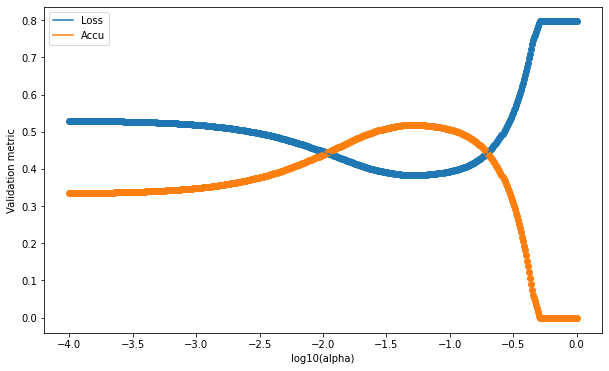

In [89]:
# Plot Loss vs point in grid search
data_lasso = pd.read_csv('grid_search_lasso_a.csv')

fig, axes = plt.subplots(figsize=(10,6))

axes.scatter(np.log10(data_lasso.alpha), data_lasso['valid_loss'])
axes.plot(np.log10(data_lasso.alpha), data_lasso['valid_loss'], label='Loss')

axes.scatter(np.log10(data_lasso.alpha), data_lasso['valid_accu'])
axes.plot(np.log10(data_lasso.alpha), data_lasso['valid_accu'], label='Accu')

axes.set_xlabel("log10(alpha)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

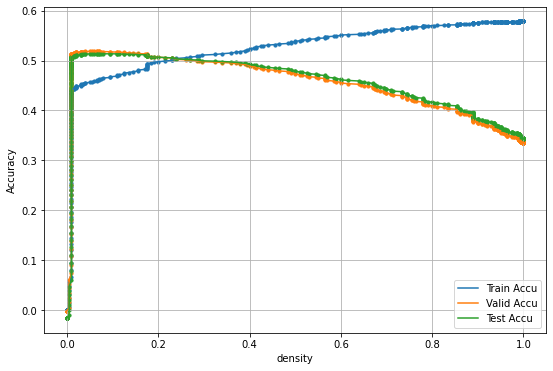

In [90]:
# Plot Acc vs sparsity
data_lasso = pd.read_csv('grid_search_lasso_a.csv')

fig, axes = plt.subplots(figsize=(9,6))

axes.scatter(data_lasso['sparcity'], data_lasso['train_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['train_accu'], label='Train Accu')

axes.scatter(data_lasso['sparcity'], data_lasso['valid_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['valid_accu'], label='Valid Accu')

axes.scatter(data_lasso['sparcity'], data_lasso['test_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['test_accu'], label='Test Accu')

axes.set_xlabel("density")
axes.set_ylabel("Accuracy")
axes.legend()
axes.grid(True)
plt.show()

In [91]:
# Display grid search results
data_lasso = pd.read_csv('grid_search_lasso_a.csv')

idx = data_lasso.valid_loss.idxmin()
best_alpha = data_lasso.loc[idx, 'alpha']

print("Parameters at Valid. Min.:\n")
print(data_lasso.iloc[idx, :])

Parameters at Valid. Min.:

iteration     337.000000
alpha           0.049361
sparcity        0.065000
valid_loss      0.383252
train_loss      0.540473
test_loss       0.392159
valid_accu      0.518342
train_accu      0.459527
test_accu       0.513502
Name: 336, dtype: float64


In [92]:
# Train with best hyperparameters
params['alpha'] = best_alpha
log_reg = Lasso(**params).fit(xtrain, ytrain.numpy().ravel())
joblib.dump(log_reg, 'model_lasso_valid_min_a.pkl')

['model_lasso_valid_min_a.pkl']

In [93]:
# Find MSE, R2, Accuracy, etc...
model = joblib.load('model_lasso_valid_min_a.pkl')

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                          columns=['accuracy', 'loss'])

ypred = model.predict(xtrain.numpy())
df_results.loc['train', 'accuracy'] = r2_score(ytrain.numpy(), ypred)
df_results.loc['train', 'loss'] = mean_squared_error(ytrain.numpy(), ypred, squared=True)

ypred = model.predict(xvalid.numpy())
df_results.loc['valid', 'accuracy'] = r2_score(yvalid, ypred)
df_results.loc['valid', 'loss'] = mean_squared_error(yvalid.numpy(), ypred, squared=True)

ypred = model.predict(xtest.numpy())
df_results.loc['test', 'accuracy'] = r2_score(ytest.numpy(), ypred)
df_results.loc['test', 'loss'] = mean_squared_error(ytest.numpy(), ypred, squared=True)

# Save data
df_results.to_csv('accuracy_lasso_valid_min_a.csv', index=True)
df_results.head()

,accuracy,loss
train,0.459527,0.540473
valid,0.518342,0.383252
test,0.513502,0.392159


## Forward ResNet

In [7]:
# Load best forward model
n_features = len(cols_X)
n_layers = [11, 1]
model = MyNetRes(n_features, n_layers)
model.eval()

MyNetRes(
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=200, out_features=11, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 545
Best validation at iteration = 132


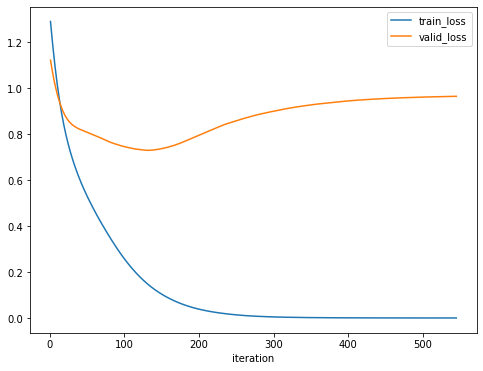

In [76]:
# TRAIN FORWARD
lockdown_unconstraint = ld.lockdown(model, lr=1e-3, loss_type=1, optim_id=2)

lockdown_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-6,
                            train_how="unconstraint", reset_weights=True)

lockdown_unconstraint.path_data.plot(x="iteration", 
                                     y=['train_loss', 'valid_loss'], 
                                     figsize=(8,6))
plt.show()

In [77]:
# Save model, data
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_valid_min_a_resnet.pth')
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_last_a_resnet.pth')
lockdown_unconstraint.path_data.to_csv('data_forward_a_resnet.csv')

In [78]:
# Accuracy
mm = MyNetRes(n_features, n_layers)
mm.load_state_dict(torch.load('./model_forward_valid_min_a_resnet.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.8544
Valid R2 = 0.0824
Test R2  = 0.0972


## Forward

In [100]:
# Load best forward model
n_features = len(cols_X)
n_layers = [10, 1]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 2022
Best validation at iteration = 17


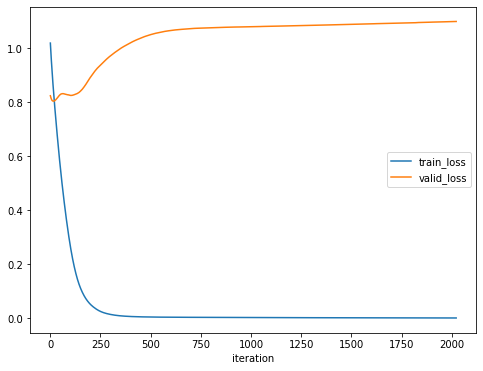

In [62]:
# TRAIN FORWARD
lockdown_unconstraint = ld.lockdown(model, lr=1e-3, loss_type=1, optim_id=2)

lockdown_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-6,
                            train_how="unconstraint", reset_weights=True)

lockdown_unconstraint.path_data.plot(x="iteration", 
                                     y=['train_loss', 'valid_loss'], 
                                     figsize=(8,6))
plt.show()

In [63]:
# Save model, data
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_valid_min_a.pth')
tp.save_model(lockdown_unconstraint.model_last, 'model_forward_last_a.pth')
lockdown_unconstraint.path_data.to_csv('data_forward_a.csv')

In [64]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./model_forward_valid_min_a.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.1629
Valid R2 = -0.0104
Test R2  = -0.0315


## LassoNet

In [394]:
!python '/Users/arbelogonzalezw/Documents/ML_WORK/LassoNet/lassonet/examples/miceprotein.py'

## Lockout ResNet

In [80]:
# TRAIN WITH LOCKOUT
model = MyNetRes(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_last_a_resnet.pth'))
model.eval()

regul_type = [('fc1.weight', 1)]
regul_path = [('fc1.weight', True)]

t0_grid = {'fc1.weight': torch.from_numpy(np.geomspace(122.119652, 1e-2, num=100, endpoint=False))}
t0      = {'fc1.weight': torch.tensor(24.869976)}

lockdown_reg = ld.lockdown(model, lr=1e-2, 
                           regul_type=regul_type,
                           regul_path=regul_path, 
                           loss_type=1, tol_grads=1e-3)

In [81]:
lockdown_reg.train(dl_train, dl_valid, dl_test, epochs=100000, early_stop=20, tol_loss=1e-4,
                   train_how="decrease_t0")

Epochs1:   0%|          | 0/100000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 348


Epochs2:   0%|          | 0/100000 [00:00<?, ?it/s]

Best validation at iteration = 98853


In [82]:
# Save model, data
tp.save_model(lockdown_reg.model_best_valid, 'model_lockdown_valid_min_a_resnet.pth')
tp.save_model(lockdown_reg.model_last, 'model_lockdown_last_a_resnet.pth')
lockdown_reg.path_data.to_csv('data_lockdown_a_resnet.csv')

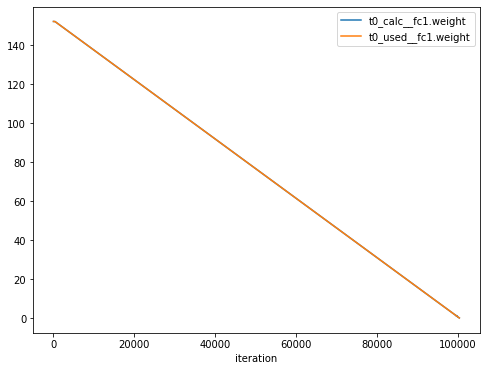

In [83]:
# Relevant plots
df = pd.read_csv('data_lockdown_a_resnet.csv')
df.plot(x="iteration", y=['t0_calc__fc1.weight', 't0_used__fc1.weight'], 
        figsize=(8,6))
plt.show()

In [84]:
# Accuracy
mm = MyNetRes(n_features, n_layers)
mm.load_state_dict(torch.load('./model_lockdown_valid_min_a_resnet.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.7685
Valid R2 = 0.8353
Test R2  = 0.8258


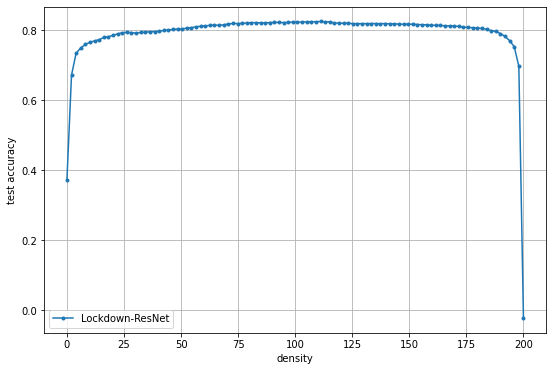

In [10]:
# Accuracy vs Sparcity
data_lockdown = pd.read_csv('data_lockdown_a_resnet.csv', index_col=0)
data_tmp_res = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown['sparcity__fc1.weight'] < x+step)
    train_accu = data_lockdown.loc[msk, 'train_accu'].mean()
    valid_accu = data_lockdown.loc[msk, 'valid_accu'].mean()
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'train_accu': train_accu, 
                                'valid_accu': valid_accu, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(200*data_tmp_res['sparcity'], data_tmp_res['test_accu'], ".-", label='Lockdown-ResNet')

axes.grid(True)
axes.set_xlabel("density")
axes.set_ylabel("test accuracy")
axes.legend()

plt.show()

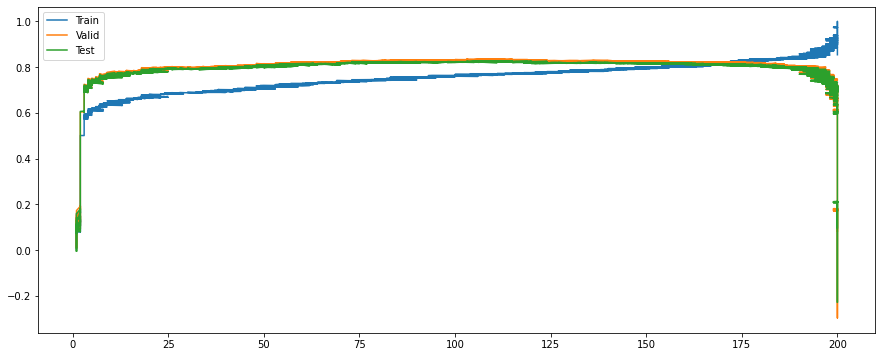

In [86]:
# 1000, 200, std=0.5
data_lockdown = pd.read_csv('data_lockdown_a_resnet.csv', index_col=0)

fig, axes = plt.subplots(figsize=(15,6))

axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['train_accu'], label='Train')
axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['valid_accu'], label='Valid')
axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['test_accu'], label='Test')

axes.legend()
plt.show()

## Lockout

In [66]:
# TRAIN WITH LOCKOUT
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_last_a.pth'))
model.eval()

regul_type = [('classifier.0.weight', 1)]
regul_path = [('classifier.0.weight', True)]

t0_grid = {'classifier.0.weight': torch.from_numpy(np.geomspace(74.083328, 1e-2, num=100, endpoint=False))}
t0      = {'classifier.0.weight': torch.tensor(24.869976)}

lockdown_reg = ld.lockdown(model, lr=1e-2, 
                           regul_type=regul_type,
                           regul_path=regul_path, 
                           loss_type=1, tol_grads=1e-3)

In [67]:
lockdown_reg.train(dl_train, dl_valid, dl_test, epochs=100000, early_stop=20, tol_loss=1e-4,
                   train_how="decrease_t0")

Epochs1:   0%|          | 0/100000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 20


Epochs2:   0%|          | 0/100000 [00:00<?, ?it/s]

Best validation at iteration = 99113


In [68]:
# Save model, data
tp.save_model(lockdown_reg.model_best_valid, 'model_lockdown_valid_min_a.pth')
tp.save_model(lockdown_reg.model_last, 'model_lockdown_last_a.pth')
lockdown_reg.path_data.to_csv('data_lockdown_a.csv')

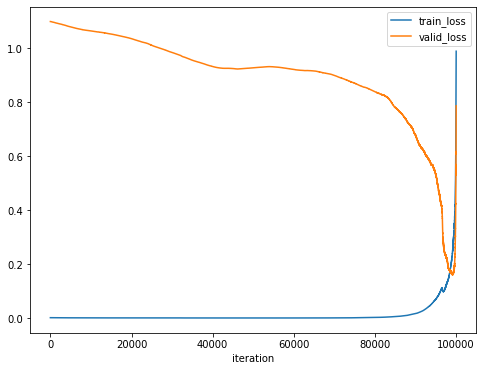

In [69]:
# Relevant plots
df = pd.read_csv('data_lockdown_a.csv')
df.plot(x="iteration", y=['train_loss', 'valid_loss'], figsize=(8,6))
plt.show()

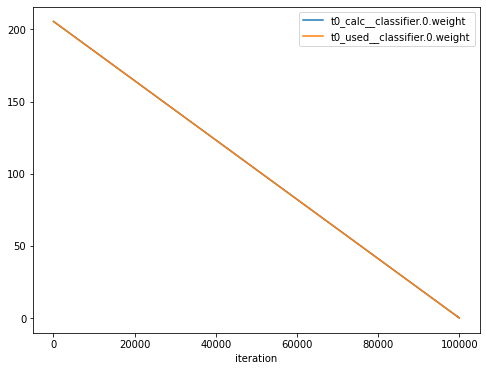

In [70]:
# Relevant plots
df = pd.read_csv('data_lockdown_a.csv')
df.plot(x="iteration", y=['t0_calc__classifier.0.weight', 't0_used__classifier.0.weight'], 
        figsize=(8,6))
plt.show()

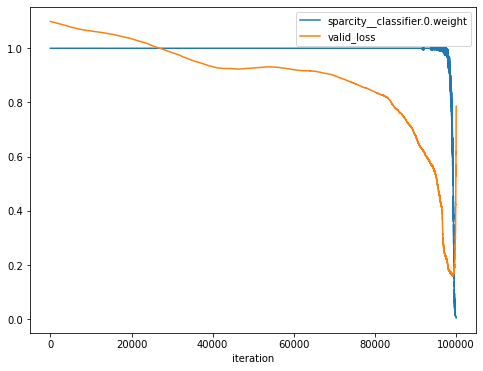

In [71]:
# Relevant plots
df = pd.read_csv('data_lockdown_a.csv')
df.plot(x="iteration", y=['sparcity__classifier.0.weight', 'valid_loss'], 
        figsize=(8,6))
plt.show()

In [72]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./model_lockdown_valid_min_a.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.7534
Valid R2 = 0.7987
Test R2  = 0.7901


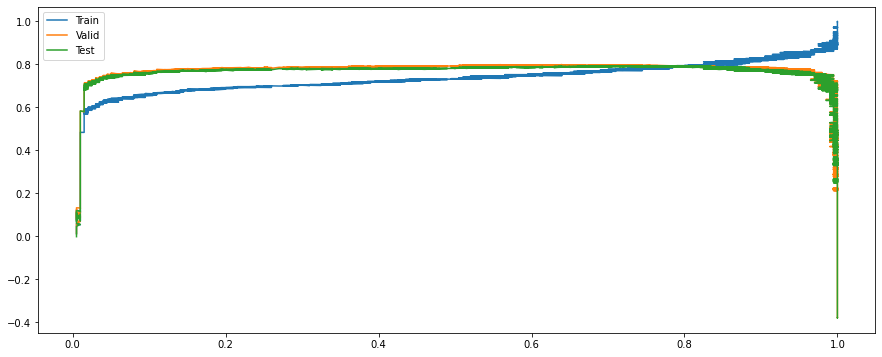

In [73]:
# 1000, 200, std=0.5
data_lockdown = pd.read_csv('data_lockdown_a.csv', index_col=0)
# data_lockdown = data_lockdown.sort_values(by=['iteration'], 
#                                           ascending=True)

fig, axes = plt.subplots(figsize=(15,6))

axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['train_accu'], label='Train')
axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['valid_accu'], label='Valid')
axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['test_accu'], label='Test')

axes.legend()
plt.show()

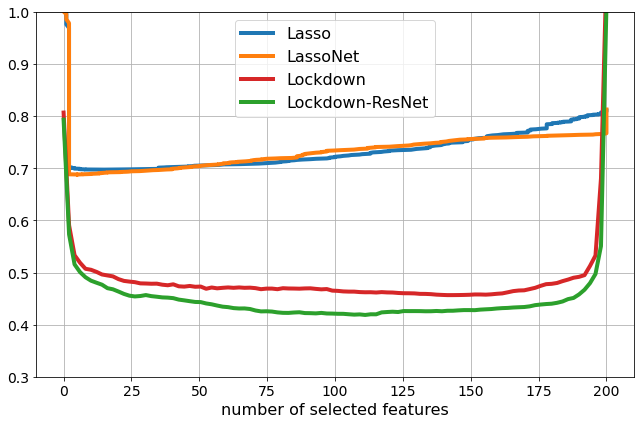

In [2]:
# Acc. v Sparcity (smooth)
data_lockdown     = pd.read_csv('data_lockdown_a.csv',        index_col=0)
data_lockdown_res = pd.read_csv('data_lockdown_a_resnet.csv', index_col=0)
data_lasso        = pd.read_csv('grid_search_lasso_a.csv')
data_lassonet     = pd.read_csv('lassonet_data_a.csv')

data_tmp     = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])
data_tmp_res = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])

xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

    msk = (data_lockdown_res['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown_res['sparcity__fc1.weight'] < x+step)
    test_accu  = data_lockdown_res.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown_res.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

data_tmp.dropna(axis='index', how='any', inplace=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

# Accuracy vs Sparcity
fig, axes = plt.subplots(figsize=(9,6))

axes.plot(200*data_lasso['sparcity'], np.sqrt(1.0 - data_lasso['test_accu']), 
          "-", label='Lasso', linewidth=4, markersize=10)
axes.plot(data_lassonet['features'], np.sqrt(1.0 -  data_lassonet['accuracy']), 
          "-", label='LassoNet', linewidth=4, markersize=10)
axes.plot(200*data_tmp['sparcity'], np.sqrt(1.0 -  data_tmp['test_accu']), 
          "-", label='Lockdown', linewidth=4, markersize=10, color="tab:red")
axes.plot(200*data_tmp_res['sparcity'], np.sqrt(1.0 -  data_tmp_res['test_accu']), 
          "-", label='Lockdown-ResNet', linewidth=4, markersize=10, color="tab:green")

axes.grid(True, zorder=2)
axes.set_xlabel("number of selected features", fontsize=16)
# axes.set_ylabel("Relative Root Mean Squared Error", fontsize=16)
axes.legend(fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylim(0.3, 1.0)

plt.tight_layout()
plt.savefig("outputs_a/error_vs_density_a.pdf", bbox_inches='tight')
plt.show()

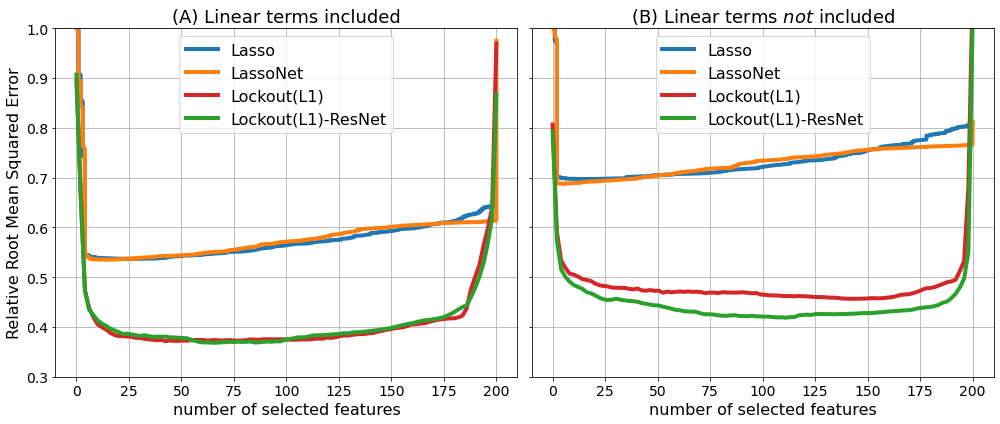

In [11]:
# Acc. v Sparcity (smooth)
data_lockdown     = pd.read_csv('data_lockdown_a.csv',        index_col=0)
data_lockdown_res = pd.read_csv('data_lockdown_a_resnet.csv', index_col=0)
data_lasso        = pd.read_csv('grid_search_lasso_a.csv')
data_lassonet     = pd.read_csv('lassonet_data_a.csv')

data_tmp     = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])
data_tmp_res = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])

xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

    msk = (data_lockdown_res['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown_res['sparcity__fc1.weight'] < x+step)
    test_accu  = data_lockdown_res.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown_res.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

data_tmp.dropna(axis='index', how='any', inplace=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

# Accuracy vs Sparcity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

axes[1].plot(200*data_lasso['sparcity'], np.sqrt(1.0 - data_lasso['test_accu']), 
          "-", label='Lasso', linewidth=4, markersize=10)
axes[1].plot(data_lassonet['features'], np.sqrt(1.0 -  data_lassonet['accuracy']), 
          "-", label='LassoNet', linewidth=4, markersize=10)
axes[1].plot(200*data_tmp['sparcity'], np.sqrt(1.0 -  data_tmp['test_accu']), 
          "-", label='Lockout(L1)', linewidth=4, markersize=10, color="tab:red")
axes[1].plot(200*data_tmp_res['sparcity'], np.sqrt(1.0 -  data_tmp_res['test_accu']), 
          "-", label='Lockout(L1)-ResNet', linewidth=4, markersize=10, color="tab:green")

axes[1].grid(True, zorder=2)
axes[1].set_xlabel("number of selected features", fontsize=16)
# axes.set_ylabel("Relative Root Mean Squared Error", fontsize=16)
axes[1].legend(fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_ylim(0.3, 1.0)
axes[1].set_yticklabels([])
axes[1].set_title("(B) Linear terms $\it{not}$ included", fontsize=18)

# Acc. v Sparcity (smooth)
data_lockdown     = pd.read_csv('data_lockdown_b.csv',        index_col=0)
data_lockdown_res = pd.read_csv('data_lockdown_b_resnet.csv', index_col=0)
data_lasso        = pd.read_csv('grid_search_lasso_b.csv')
data_lassonet     = pd.read_csv('lassonet_data_b.csv')

data_tmp     = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])
data_tmp_res = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])

xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

    msk = (data_lockdown_res['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown_res['sparcity__fc1.weight'] < x+step)
    test_accu  = data_lockdown_res.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown_res.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

data_tmp.dropna(axis='index', how='any', inplace=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

# Accuracy vs Sparcity
axes[0].plot(200*data_lasso['sparcity'], np.sqrt(1.0 - data_lasso['test_accu']), 
          "-", label='Lasso', linewidth=4, markersize=10)
axes[0].plot(data_lassonet['features'], np.sqrt(1.0 -  data_lassonet['accuracy']), 
          "-", label='LassoNet', linewidth=4, markersize=10)
axes[0].plot(200*data_tmp['sparcity'], np.sqrt(1.0 -  data_tmp['test_accu']), 
          "-", label='Lockout(L1)', linewidth=4, markersize=10, color="tab:red")
axes[0].plot(200*data_tmp_res['sparcity'], np.sqrt(1.0 -  data_tmp_res['test_accu']), 
          "-", label='Lockout(L1)-ResNet', linewidth=4, markersize=10, color="tab:green")

axes[0].grid(True, zorder=2)
axes[0].set_xlabel("number of selected features", fontsize=16)
axes[0].set_ylabel("Relative Root Mean Squared Error", fontsize=16)
axes[0].legend(fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_ylim(0.3, 1.0)
axes[0].set_title("(A) Linear terms included", fontsize=18)


plt.tight_layout()
plt.savefig("outputs_a/error_vs_density_ba.pdf", bbox_inches='tight')
plt.show()